<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/decomposing_GPR_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Installing extra packages on the current session
I use "george packages for the Gaussian Process analysis
Please visit here for further details: https://george.readthedocs.io/en/latest/user/kernels/


In [1]:
!pip install george


# Importing packages


In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import george
from george import kernels
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load data
data preparation
We generate the first 3 main principal components that capture the most useful information of the data. P1, P2 and P3 are not correalted with each other while they are epressed as the linear cominination of the available featurdes, i.e. ET0, VPD, Rn and T (air temperature)

**Note:** Make sure that the data file is addressed correctly and it's already avaialble in your Google drive.

In [3]:

# dataFile = 'Changde.xlsx'  
# dataFile = 'Hailisu.xlsx'  
dataFile = 'Lancang.xlsx'  
# dataFile = 'Miyun.xlsx'  
# dataFile = 'Nanmulin.xlsx'  
# dataFile = 'Qiemo.xlsx'

data = pd.read_excel('/content/drive/My Drive/'+ dataFile)

In [4]:
# revising the column names
for col in data.columns:
  newcol = col.split("(")[0].strip()
  data.rename(columns={col:newcol}, inplace=True)

# setting up the index of the data frame
data.set_index("TIMESTAMP", inplace=True)

# resample data daily, forward linear interpolation to fill the missing values
data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

## Optional:
## Generating the first three principal (P1, P2, P3) components basesd on ET0, VPD, Rn and T.
myData = data[["ET0", "VPD", "Rn", "T"]].ffill()
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(myData)
pca_data = PCA().fit_transform(z_data);
pca_trafo = PCA().fit(z_data);
data["P1"] = pca_data[:,0]
data["P2"] = pca_data[:,1]
data["P3"] = pca_data[:,3]

# displaying the first couple rows of the data table
data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3
TIMESTAMP,,,,,,,,,,,,,,,
1990-01-01,1,0.8,12.0,9.7,74.0,5.7,23.7,6.322565,0.340811,0.092480,0.067364,1.664516,-2.573261,1.073222,0.020169
1990-01-02,2,0.3,11.5,9.1,74.0,4.2,24.9,6.176976,0.319730,0.089835,0.067364,1.504496,-2.791777,1.111466,-0.051769
1990-01-03,3,0.3,13.2,10.5,74.0,5.1,25.6,6.420850,0.368919,0.099101,0.067364,1.633013,-2.386472,0.885485,-0.077866
1990-01-04,4,0.8,13.2,10.6,73.0,5.0,25.3,6.540410,0.392055,0.099101,0.067364,1.790649,-2.224977,0.956440,0.007272
1990-01-05,5,1.0,12.5,9.4,71.0,6.3,25.4,6.157584,0.383944,0.095192,0.067364,1.729121,-2.431196,1.072196,0.062343


In [5]:
import pywt

n_take = len(data)
n_level = 3
waveletname = 'db4'
SharpData = data['ET0'].values

data3 = pywt.downcoef('a', SharpData, waveletname, level=n_level)
data["Wa3"] = pywt.upcoef('a', data3, waveletname, level=n_level, take=n_take)

for i in range(n_level): 
  res = pywt.downcoef('d', SharpData, waveletname, level=i+1)
  data['Wd'+str(i+1)] = pywt.upcoef('d', res, waveletname, level=i+1, take=n_take)

data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3,Wa3,Wd1,Wd2,Wd3
TIMESTAMP,,,,,,,,,,,,,,,,,,,
1990-01-01,1,0.8,12.0,9.7,74.0,5.7,23.7,6.322565,0.340811,0.092480,0.067364,1.664516,-2.573261,1.073222,0.020169,1.640756,0.024654,0.033286,-0.034180
1990-01-02,2,0.3,11.5,9.1,74.0,4.2,24.9,6.176976,0.319730,0.089835,0.067364,1.504496,-2.791777,1.111466,-0.051769,1.655154,-0.044428,-0.081998,-0.024233
1990-01-03,3,0.3,13.2,10.5,74.0,5.1,25.6,6.420850,0.368919,0.099101,0.067364,1.633013,-2.386472,0.885485,-0.077866,1.669552,0.033933,-0.054389,-0.016083
1990-01-04,4,0.8,13.2,10.6,73.0,5.0,25.3,6.540410,0.392055,0.099101,0.067364,1.790649,-2.224977,0.956440,0.007272,1.683662,0.020334,0.101506,-0.014853
1990-01-05,5,1.0,12.5,9.4,71.0,6.3,25.4,6.157584,0.383944,0.095192,0.067364,1.729121,-2.431196,1.072196,0.062343,1.703232,-0.040984,0.068441,-0.001569


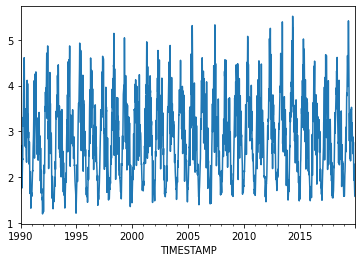

In [6]:
data["Wa3"].plot()

# Data Exploration

# Staging some data for ML modeling


Generating train and test data sets.
For the sake of speed, we use use a fraction of data for evaluation of our algorithm. Later to get the final results, we use the entire data set.

Text(0.5, 0, 'Time')

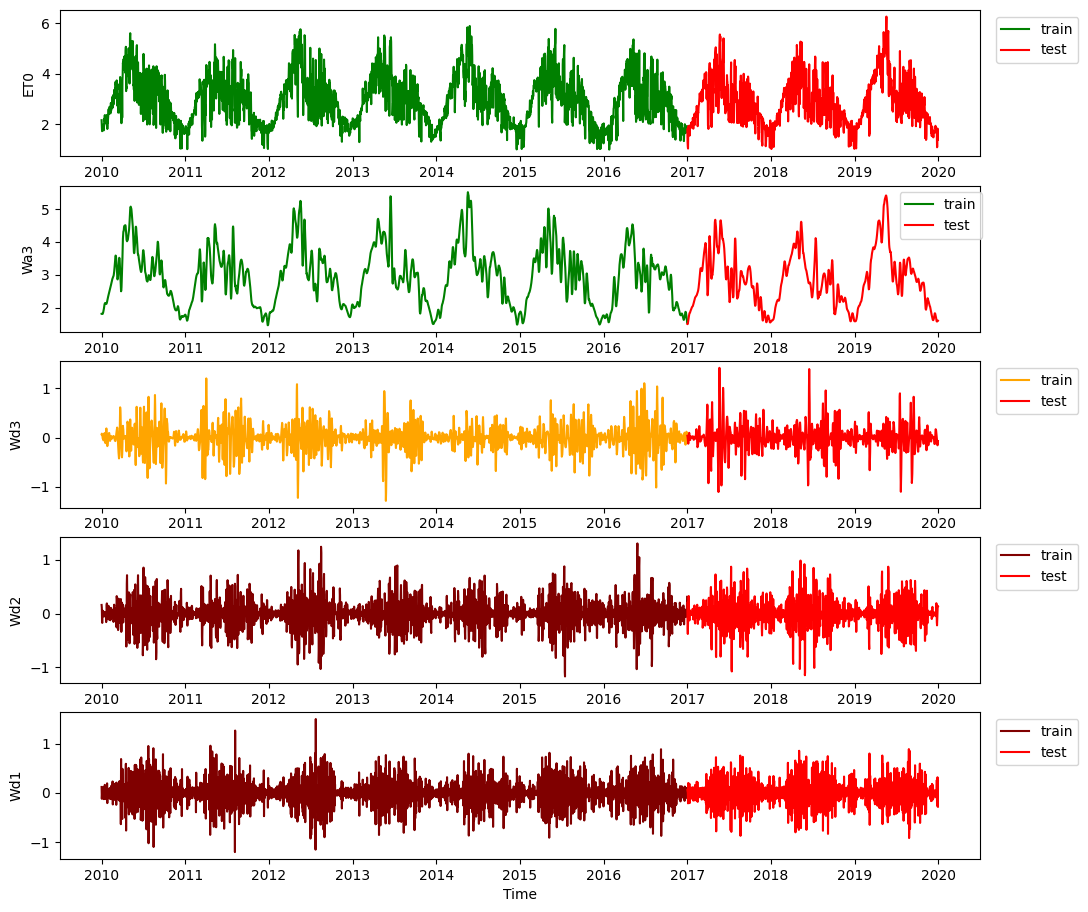

In [7]:
fig = py.figure(figsize=(10,15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(7,1) ; p=0

# training: 2010-2017
subData = data.loc["2010":"2016-12-31"]
N = len(subData)
x = subData.index
y = subData["ET0"].ffill()
z = subData["Wa3"].ffill()
v = subData["Wd3"].ffill()
w = subData["Wd2"].ffill()
u = subData["Wd1"].ffill()

# testing: 2013 onward
subData_test = data.loc["2017":]
N_test = len(subData_test)
x_test = subData_test.index
y_test = subData_test["ET0"].ffill()
z_test = subData_test["Wa3"].ffill()
v_test = subData_test["Wd3"].ffill()
w_test = subData_test["Wd2"].ffill()
u_test = subData_test["Wd1"].ffill()

# top plot 
p = 0

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, y, color='green', label="train")
ax.plot(x_test, y_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("ET0")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, z, color='green', label="train")
ax.plot(x_test, z_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("Wa3")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, v, color='orange', label="train")
ax.plot(x_test, v_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("Wd3")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, w, color='maroon', label="train")
ax.plot(x_test, w_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("Wd2")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, u, color='maroon', label="train")
ax.plot(x_test, u_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("Wd1")

ax.set_xlabel("Time")

In [8]:
def metrics(y1, y2):
  '''
  y1 and y2 are two series of the same size

  This function outputs the MAE, RMSE and R^2 
  of the cross evaluated series.

  '''
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################

def funcMAX(func, X, y, addParam = 0, maxiter=500, method='L-BFGS-B', verbose=False):
  
  '''
  A function to find the optimum parameters of the input funtion "func",
  where yp = func(X) and RMSE(y-yp) is minimzed

  output: "results" is the object that contains everything about the fit
  result.x holds the optimized parameters
  '''

  t1 =  datetime.now()  # t1 and t2 are used for timing this process
  ###########################################
  n = X.shape[1]
  # Maximum Likelihood
  Param_init = np.random.rand(n+addParam)
  result = minimize(func(X, y), Param_init, 
                method=method, options={"maxiter":maxiter})
  print("--------------------")
  if verbose:
    print(result)
  ###########################################
  if not verbose: 
    print("Fit Success: ", result.success)
  t2 =  datetime.now()
  print("Execution time: ", t2-t1)
  print("--------------------")

  return result

In [9]:



def dataPrepare2(y, n = 3, d = 1):

  N = len(y)
  dd = d - 1

  XS = np.zeros((N-n-dd, 3*n))
  ys = np.zeros(N-n-dd)

  p = 0 

  for i in range(20, N-n-dd):
    if not np.isnan(y[i:i+n]).any() and not np.isnan(y[i+n+dd]):
      
      SharpData = y[i-10:i+n]
      n_take = len(SharpData)

      z = np.asarray([np.mean(SharpData[i-5:i]) for i in range(5, n_take)])
      v = np.asarray([np.mean(SharpData[i-3:i]) for i in range(3, n_take)])
      w = np.asarray([SharpData[i]-SharpData[i-1] for i in range(1, n_take)])


      XS[p,:n]      = z[n_take-n-5:n_take-5]     
      XS[p,n:2*n]   = v[n_take-n-3:n_take-3]
      XS[p,2*n:3*n] = w[n_take-n-1:n_take-1] 

      ys[p] = y[i+n+dd]
      p+=1

  return XS[:p,:], ys[:p]

In [10]:
from sklearn.model_selection import train_test_split

def GPR(X, y, lnlikelihood=True):
  '''
  The output of this function is another function, either the lnlikelihood, or 
  the gp (the gaussian process regressor that is dfined by giving theta)
  '''
  n = X.shape[1]
    
  def step(theta):

        L = np.exp(theta[:n])
        sigma = np.exp(theta[n])   
        yerr = np.exp(theta[n+1])
        
        kernel = sigma * kernels.ExpSquaredKernel(np.ones(n), ndim=n)

        gp = george.GP(kernel)

        if lnlikelihood:
          gp = george.GP(kernel)
          gp.compute(X / np.vstack([L]*X.shape[0]), yerr)
       
          return -gp.lnlikelihood(y)
        else:
          X0 = X / np.vstack([L]*X.shape[0])
          gp.compute(X0, yerr)
          return gp
      
  return step

# Preparing the feature matrix, X, and the target vector, y
for the given training and cross_validation sets.

In the following example for mDelay=3, 3*4 features would be generated. 3-lags, four parameters each. So $X$ is 12-dimensional

In [11]:
# y: ET0 
# z: P1 (the first principal component)
# v: T (temperature)
# w: VPD

mDelay = 14
nAhead = 1

XS2, ys2 = dataPrepare2(y, n=mDelay, d=nAhead)
XS_test2, ys_test2 = dataPrepare2(y_test, n=mDelay, d=nAhead)

n_components = 3*mDelay

# Optional dimension reduction

Since the number of dimensions could be large, we can project all paraeters to a principal compnent space with lower dimensions. 

For instance, running the following cell, for n_components = 5, only 5 strongest components are utilized. Another advantage is that these 5 components are independent and not correlated. If the number of features is larges, using too small number components implies information leakage. 

# PSO with PySwarm
Optimizing the GPR hyperparameters using the Particle Swarm Optimizer

https://pyswarms.readthedocs.io/en/latest/index.html

In [12]:
!pip install pyswarms

In [13]:

# Import modules
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [14]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits(XS2)

def Xi2_swarm(x):
  
  nParticle = x.shape[0]
  out = np.zeros(nParticle)

  for train_index, cross_index in kf.split(XS2):
    
      X_train, X_cross = XS2[train_index], XS2[cross_index]
      y_train, y_cross = ys2[train_index], ys2[cross_index]

      n = X_cross.shape[1]
      m = X_cross.shape[0]

      for n_iter in range(nParticle):
          
          theta = x[n_iter,:]

          L = np.exp(theta[:n])

          gp = GPR(X_train, y_train, lnlikelihood=False)(theta)
          gp_yp_cross, gp_yp_cross_std = gp.predict(y_train, X_cross/np.vstack([L]*m), return_var=True)

          out[n_iter] += np.sum((y_cross - gp_yp_cross)**2)

  return out

In [15]:
%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = GlobalBestPSO(n_particles=10, dimensions=n_components+2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(Xi2_swarm, iters=10)

2020-12-03 06:51:35,998 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=690
2020-12-03 06:57:42,941 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 690.1265659000891, best pos: [3.23304003 3.10761505 4.33771247 3.54978721 2.471067   4.52674131
 5.05976246 4.49517594 3.44410719 3.23154047 3.43477935 3.17174544
 3.76226611 4.8451526  3.1968523  1.97228021 5.07470585 2.96474841
 2.68378262 2.90638909 3.95538928 5.32215833 4.1226213  3.53410461
 3.26983103 2.18182126 5.16908689 6.02894308 1.67440704 3.26315438
 4.00647328 0.10171625]


CPU times: user 8min 27s, sys: 1min 52s, total: 10min 19s
Wall time: 6min 6s


In [16]:
pos

array([3.23304003, 3.10761505, 4.33771247, 3.54978721, 2.471067  ,
       4.52674131, 5.05976246, 4.49517594, 3.44410719, 3.23154047,
       3.43477935, 3.17174544, 3.76226611, 4.8451526 , 3.1968523 ,
       1.97228021, 5.07470585, 2.96474841, 2.68378262, 2.90638909,
       3.95538928, 5.32215833, 4.1226213 , 3.53410461, 3.26983103,
       2.18182126, 5.16908689, 6.02894308, 1.67440704, 3.26315438,
       4.00647328, 0.10171625])

In [17]:
truths = pos
gp = GPR(XS2, ys2, lnlikelihood=False)(truths)


n = XS2.shape[1]
m_test = XS_test2.shape[0]
m = XS2.shape[0]

L = np.exp(truths[:n])


gp_yp, gp_yp_std = gp.predict(ys2, XS2/np.vstack([L]*m), return_var=True)
gp_yp_test, gp_yp_test_std = gp.predict(ys2, XS_test2/np.vstack([L]*m_test), return_var=True)

In [18]:
print("Training set: ")
metrics(ys2, gp_yp)
print("----------------------")
print("----------------------")
print("Test set: ")
metrics(ys_test2, gp_yp_test)


Training set: 
MAE: 0.38  RMSE: 0.51  R^2: 0.72
----------------------
----------------------
Test set: 
MAE: 0.39  RMSE: 0.52  R^2: 0.70


Text(0.5, 1.0, '1 day ahead predictions (Test)')

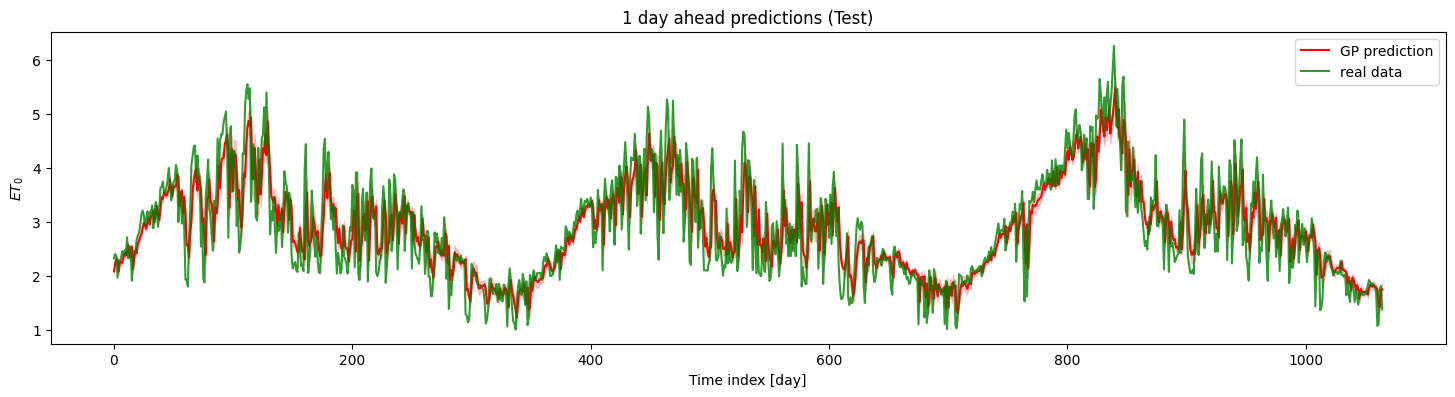

In [19]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# ax.plot(gp_yp, 'r.-',  alpha=1)
# ax.plot(ys2, 'g.-', alpha=0.8)

ax.plot(gp_yp_test, 'r-',  alpha=1, label='GP prediction')
ax.plot(ys_test2, 'g-', alpha=0.8, label='real data')

## Filling 
ax.fill_between(range(len(gp_yp_test)), gp_yp_test - 1.*np.sqrt(gp_yp_test_std), gp_yp_test + 1.*np.sqrt(gp_yp_test_std),
                color="r", alpha=0.2)

ax.legend()
# ax.set_xlim(0,500)
ax.set_ylabel("$ET_0$")
ax.set_xlabel("Time index [day]")
ax.set_title("1 day ahead predictions (Test)")

Text(0.5, 1.0, 'Changde')

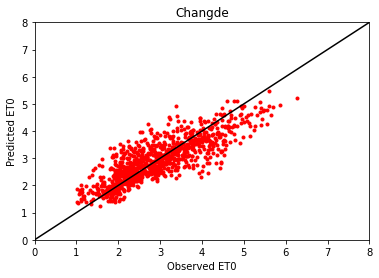

In [20]:
plt.plot(ys_test2, gp_yp_test, 'r.')

plt.plot([0, 8], [0, 8], 'k-')

plt.xlabel("Observed ET0")
plt.ylabel("Predicted ET0")

plt.xlim(0,8)
plt.ylim(0,8)
plt.title("Changde")